## Visualizing the Model Predictions

#### Primary Goal: Visualize and inspect the model predictions 
In this notebook, I'll brief tutorial for making 2D visualizations of the ML model predictions. 

In [1]:
# Import packages 
import pandas as pd
import numpy as np
import netCDF4
import h5netcdf
import xarray as xr
from os.path import join
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely
import cartopy
%matplotlib inline
import datetime as dt

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')
sys.path.append('/home/monte.flora/python_packages/WoF_post') #WoF post package
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe/')
sys.path.append('/home/samuel.varga/python_packages/VargaPy/')
from main.io import load_ml_data

In [2]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

In [ ]:
from wofs.plotting.wofs_colors import WoFSColors
from wofs_ml_severe.data_pipeline.storm_report_loader import StormReportLoader
from wofs_ml_severe.data_pipeline.storm_report_downloader import StormReportDownloader

In [ ]:
# Configuration variables (You'll need to change based on where you store your data)
#base_path = '/work/mflora/ML_2TO6HR/data'
TIMESCALE='0to3'
FRAMEWORK='ADAM'
date='20180512'
All=True
#base_path='/work/samuel.varga/data/2to6_hr_severe_wx/singleCase'
base_path=f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}/Single'

# ['20180509','20190518','20200520','20200521','20200528','20210521','20210524']

# To Do List:
Update Init time label
Update threshold label for all severe
Update hazard scale and time scale in plot label

### Load the data for the ML model and BL model.

In [86]:
# Set the target column and baseline variable. 

hazard='tornado' #use tornado for UH baseline
scale = '36km'
if TIMESCALE=='0to3':
    Vdate=str(int(date)+1) #Should probably use DT for this
    init_time = '0000' #Used to get domain-- is 1900 when making data
    title = f'Valid: {Vdate[:4]}-{Vdate[4:6]}-{Vdate[6:]} 00:00 - 03:00 UTC'
else:
    Vdate=str(int(date)+1)
    init_time='2200'
    title = f'Valid: {Vdate[:4]}-{Vdate[4:6]}-{Vdate[6:]} 00:00 - 04:00 UTC'


bl_column_dict = {'hail' :  'hailcast__nmep_>1_0_45km', 
                  'wind' :  'ws_80__nmep_>40_45km', 
                  'tornado' : 'uh_2to5_instant__nmep_>50_27km' #100, 45 || 27, 50
                 }
bl_column = bl_column_dict[hazard]

# Load the testing dataset for the ML model.
X, X_bl = load_ml_data(base_path=base_path, 
                       date=date,  
                       bl_column = bl_column, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, Big=False)

In [18]:
#dates=['20180503', '20180509', '20180511', '20180523', '20190501',
#       '20190508', '20190518', '20190520', '20190523', '20190525',
#       '20200504', '20200506', '20200513', '20200519', '20200520',
#       '20200521', '20200522', '20200528', '20210505', '20210512',
#       '20210518', '20210520', '20210521', '20210524', '20210526']

## Selection of Variables

The current dataset contains both the old 90th percentile (ens_90th), which was calculated with regression. (See nanpercentile for more information), as well as the new 90th percentile (ens_16th), 10th percentile (ens_2nd), and IQR (ens_iqr) for intrastorm variables. If original is set to true, all new variables are dropped and the old 90th percentile feature is used. If original is set to false, all new variables are used and the old 90th percentile feature is dropped. This allows us to create a control using the original variables, so that we can assess the impact of the new variables.

In [80]:
original=False
if original:
    print("Using Original Variables- Dropping IQR, 2nd lowest, 2nd highest, and intrastorm mean")
    X=X[[col for col in X.columns if 'IQR' not in col]]
    X=X[[col for col in X.columns if '2nd' not in col]]
    X=X[[col for col in X.columns if '16th' not in col]]
    #Mean of intrastorm vars
    vardic={ 'ENS_VARS':  ['uh_2to5_instant',
                            'uh_0to2_instant',
                            'wz_0to2_instant',
                            'comp_dz',
                            'ws_80',
                            'hailcast',
                            'w_up',
                            'okubo_weiss',
                    ]}
    badthings=np.array([])
    for strmvar in vardic['ENS_VARS']:
        badthings=np.append(badthings, [col for col in X.columns if 'mean' in col and strmvar in col] )

    X=X.drop(badthings, axis=1)
    
else:
    print("Using new variables- dropping old 90th percentile")
    X=X[[col for col in X.columns if '90th' not in col]] #Keeps all columns except the old 90th %ile

Using new variables- dropping old 90th percentile


### Load the ML model and BL model.

In [81]:
def get_bl_pred(X_bl, shape, hazard, scale='36km', FRAMEWORK=None, TIMESCALE=None):
    if FRAMEWORK and TIMESCALE:
        in_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}/blModels/'
    else:
        in_path = '/work/samuel.varga/projects/2to6_hr_severe_wx/blModels/' #Change this to your own path
    # Load the baseline model. 
    bl_model = joblib.load(join(in_path,f'{hazard}_baseline_model_{scale}.joblib')) #Update naming of BL models
    bl_pred = bl_model.predict(X_bl)
    bl_pred_2D = bl_pred.reshape(shape)
    
    return bl_pred_2D

def get_ml_pred(X, shape, hazard, scale='36km', model='hist', FRAMEWORK=None, TIMESCALE=None, p=0):
    if FRAMEWORK and TIMESCALE:
        in_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}/mlModels/{scale}/'
    else:
        in_path = f'/work/samuel.varga/projects/2to6_hr_severe_wx/mlModels/{scale}/{hazard}'
    
    # Load the ML model.
    ml_data = joblib.load(join(in_path,f'Varga_all_{model}_{hazard}_{scale}.joblib')) #Change this to own path

    # When the ML model is saved by the CalibratedPipelineHyperOptCV package, 
    # there are additional metadata that is stored with it. 
    # We want to load the model and the features. 
    # We want to make sure the X input as the features in correct order. 
    ml_model = ml_data['model']
    #features = ml_data['X'].columns
    features = ml_data['features']
    X = X[features]
    
    ml_pred = ml_model.predict_proba(X)[:,1]
    ml_pred_2D = ml_pred.reshape(shape)
    
    return ml_pred_2D

In [87]:
from glob import glob

if TIMESCALE=='0to3':
    indir = glob(f'/work/mflora/SummaryFiles/{date}/{init_time}/wofs_ENS_00*')[0] #0000 of the next day
else:
    indir = glob(f'/work/mflora/SummaryFiles/{date}/{init_time}/wofs_ENS_24*')[0] #0000 of the next day
print(indir)
#indir = glob(f'/work/samuel.varga/data/2to6_hr_severe_wx/SummaryFiles/{date}/{init_time}/wofs_ENS_24*')[0]

ds = xr.load_dataset(indir, decode_times=False)
lats = ds['xlat'][::3, ::3]
lons = ds['xlon'][::3, ::3]

shape = (len(lons), len(lats))

central_longitude = ds.attrs['STAND_LON']
central_latitude = ds.attrs['CEN_LAT']

standard_parallels = (ds.attrs['TRUELAT1'], ds.attrs['TRUELAT2'])
projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                 central_latitude=central_latitude,
                                 standard_parallels=standard_parallels)
crs = ccrs.PlateCarree()
data_path = '/home/monte.flora/python_packages/WoF_post/wofs/data/'
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces")

county_file = join(data_path,'COUNTIES', 'countyl010g')
reader = shpreader.Reader(county_file)
shape_feature = ShapelyFeature(reader.geometries(),
                               crs, facecolor='none', linewidth=0.2, edgecolor='black', )

def add_map_stuff(ax, states, shape_feature):
    ax.add_feature(states, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.LAKES, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.COASTLINE, linewidth=.1, facecolor='none', edgecolor="black")        
    ax.add_feature(shape_feature)
    
    
def set_extent(ax, projection , crs, lat, lons,):
    """ Set the Map extent based the WoFS domain """
    # Set the extent. 
    xs, ys, _ = projection.transform_points(
            crs,
            np.array([lons.min(), lons.max()]),
            np.array([lats.min(), lats.max()])).T
    _xlimits = xs.tolist()
    _ylimits = ys.tolist()

    # The limit is max(lower bound), min(upper bound). This will create 
    # a square plot and make sure there is no white spaces between the map
    # the bounding box created by matplotlib. This also allows us to set the
    # WoFS domain boundaries in cases where we aren't plotting WoFS data 
    # (e.g., storm reports, warning polygons, etc.) 
    lims = (max([_xlimits[0]]+[_ylimits[0]]),min([_xlimits[-1]]+[_ylimits[-1]]))
        
    ax.set_xlim(lims)
    ax.set_ylim(lims) 
    
    return ax #0000 is 0000 the next day

/work/mflora/SummaryFiles/20180524/2200/wofs_ENS_24_20180524_2200_0000.nc


In [22]:
#help(StormReportDownloader)

In [23]:
#Get the storm reports-- Should add a check to grab data if it isn't in directory
#StormReportDownloader('/work/samuel.varga/data/2to6_hr_severe_wx/reports/').get_storm_events(years=[2017])

In [83]:
from scipy.ndimage import uniform_filter, maximum_filter 
#from WoF_post.wofs.verification.lsrs.get_storm_reports import StormReports
#from WoF_post.wofs.plotting.util import decompose_file_path
#from WoF_post.wofs.plotting.wofs_colors import WoFSColors

from wofs.plotting.util import decompose_file_path
from wofs.plotting.wofs_colors import WoFSColors
#from wofs.verification.lsrs.get_storm_reports import StormReports
from wofs.verification.lsrs.get_storm_reports import StormReports

# Get the storm reports. 
comps = decompose_file_path(indir)

#if TIMESCALE=='0to3':
    #init_time = comps['VALID_DATE']+comps['VALID_TIME'] 
#    init_time = comps['VALID_DATE']+comps['INIT_TIME'] #0000 of date+1
    #init_time=str(int(comps['VALID_DATE'])+1)+'0000' #0000 of date +1
#else:
#    init_time=str(int(comps['VALID_DATE'])+1)+'0000' #0000 of date+1, which is the valid time
    
print(init_time)
print(comps['VALID_DATE']+comps['VALID_TIME'])

deltat=5
start_time=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])+dt.timedelta(minutes=int(comps['TIME_INDEX'])*deltat)).strftime('%Y%m%d%H%M')
print(start_time)
#####Need to find Dir where stormreports are located
if TIMESCALE=='0to3':
    forecast_length=180
else:
    forecast_length=240
    
report = StormReportLoader(initial_time=start_time, 
            forecast_length=forecast_length, 
            err_window=15, 
            reports_path='/work/samuel.varga/data/2to6_hr_severe_wx/reports/STORM_EVENTS_{0}-{0}.csv'.format(str(date)[0:4]), #change this
            report_type='NOAA'
            )

ds = xr.load_dataset(indir, decode_times=False)
points = report()

0000
201805250000
201805250000


In [95]:
indir = glob(f'/work/mflora/SummaryFiles/{date}/0000/wofs_ENS_24*')[0]
comps = decompose_file_path(indir)
start_time=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])+dt.timedelta(minutes=int(comps['TIME_INDEX'])*deltat)).strftime('%Y%m%d%H%M')
print(start_time)

201805250100


In [51]:
titles = {'hail' : 'Severe Hail', 
         'wind' : 'Severe Wind', 
         'tornado' : 'Tornado',
         'all': 'All Severe'}

baseline_names = {'hail' : 'Calibrated NMEP (45 km) of HAILCAST > 1.0 in',
                  'wind' : 'Calibrated NMEP (45 km) of 80-m wind speed > 40 kts',
                  'tornado' : r'Calibrated NMEP (45 km) of UH > 150 $m^2 s^{-2}$',
                  'all' : r'Calibrated NMEP (27 KM) of UH > 50 $m^2 s^{-2}$'
                 } #Need to update the UH threshold title

In [37]:
#rprt_df=geo_df.copy()
points[hazard].shape

(0, 2)

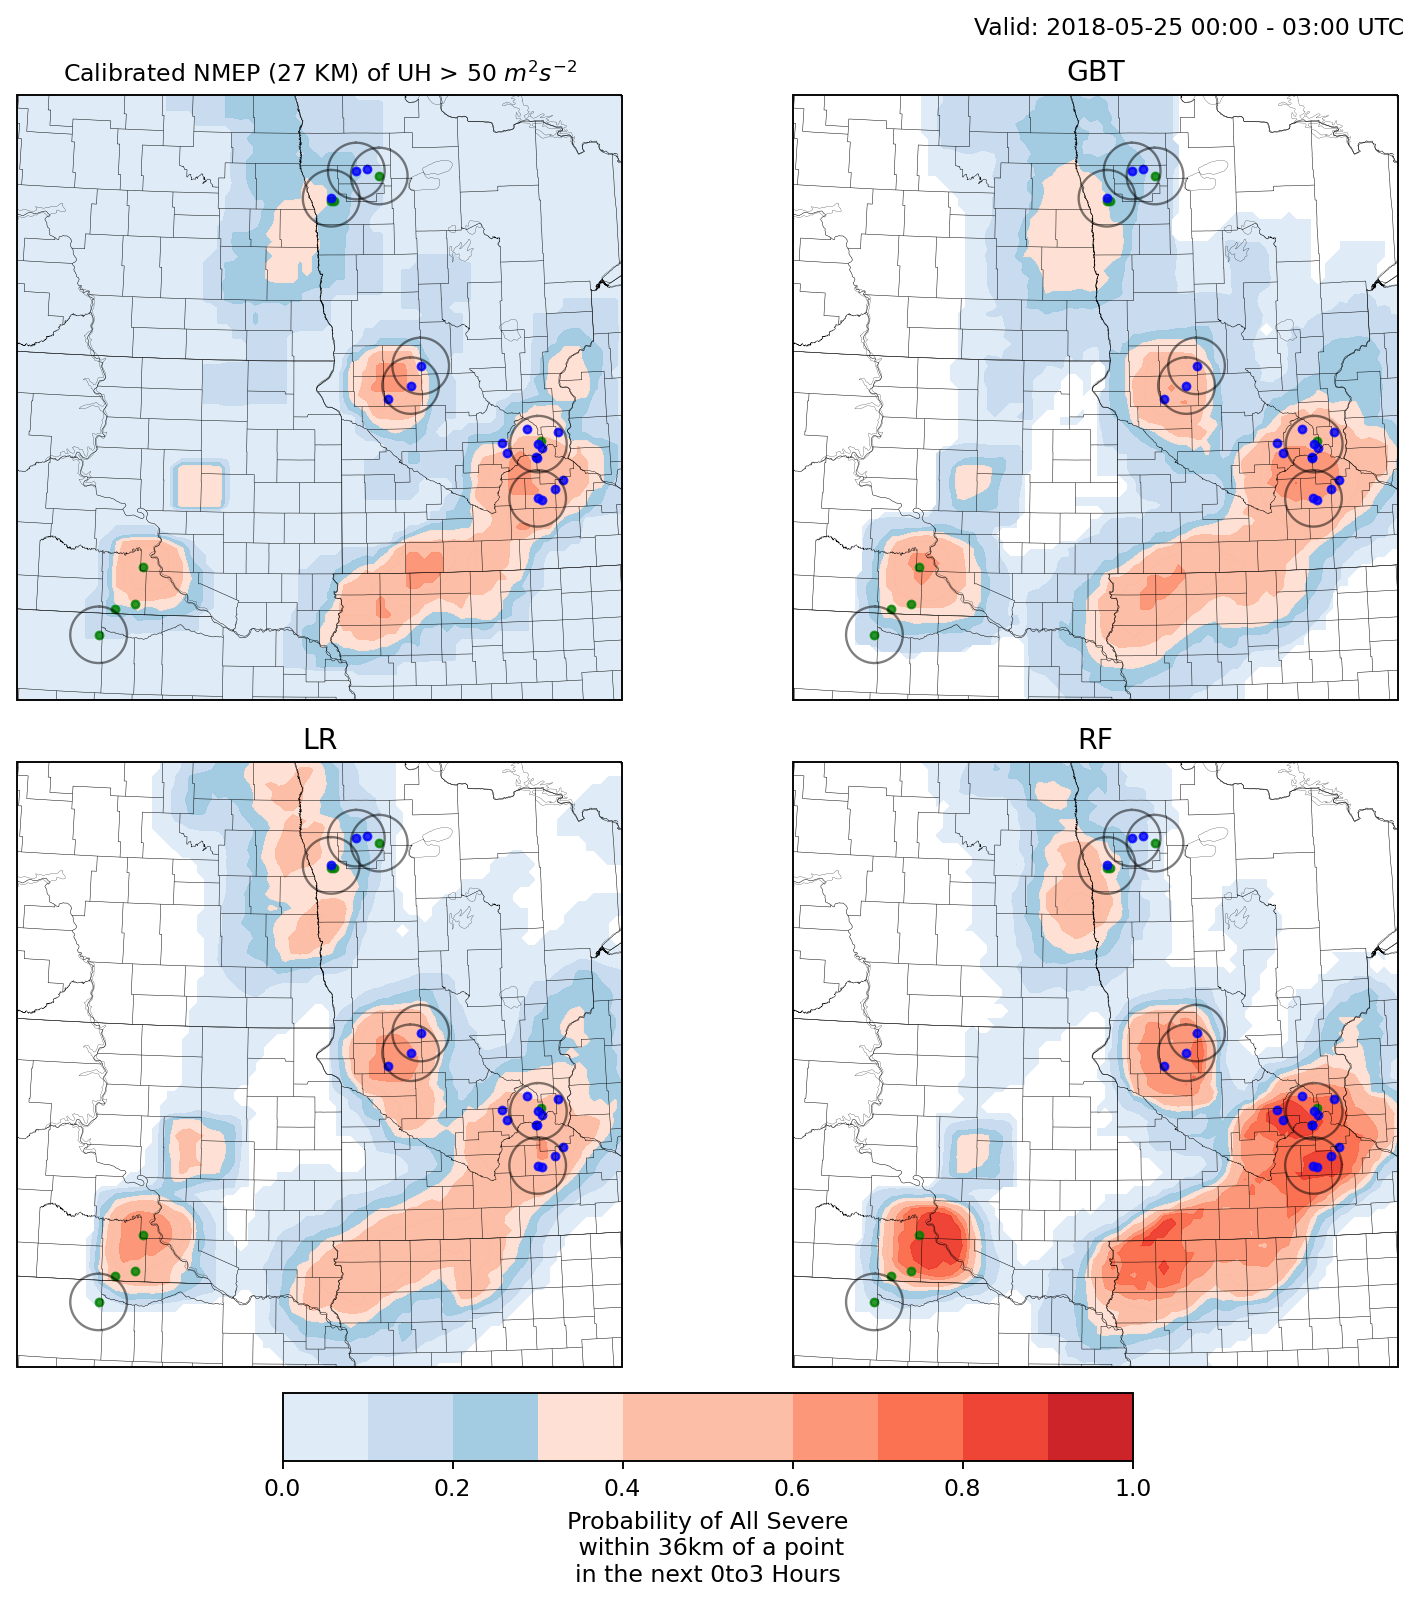

In [84]:
%matplotlib inline
hazard='all'


hazard_color = {'hail' : 'g', 'wind': 'b', 'tornado': 'r'}
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)

models = ['BL', 'hist', 'logistic', 'random'] #random/ADAM
#models = ['BL', 'hist', 'hist', 'hist']
model_names = [baseline_names[hazard], 'GBT', 'LR', 'RF']
#model_names = [baseline_names[hazard], 'GBT 10%', 'GBT 50%', 'GBT 100%']#RF/ADAM
p=[0]

if hazard != 'tornado':
    levels = np.arange(0, 1.1, 0.1)
else:
    levels = np.arange(0, 0.5, 0.001)  
    
# All 3 Models and BL
for ax, model, name in zip(axes.flat, models, model_names):
    if model == 'BL':
        pred = get_bl_pred(X_bl, shape, hazard, scale, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
    else:
        pred = get_ml_pred(X, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, p=0)
    
    add_map_stuff(ax, states, shape_feature)
    pred = np.ma.masked_where(pred<=0.025, pred)
    
    #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(lons,lats, pred, cmap=WoFSColors.wz_cmap, alpha=0.95, levels=levels,
                transform = crs, )

    ##point_lat, point_lon = points[hazard]
    if All:
        for Lorem in ['hail','wind','tornado']:
            _points=points[Lorem]
            ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[Lorem], alpha=0.8, zorder=1, transform=crs)
    else:
        _points = points[hazard]
        ax.scatter(_points[:,1],_points[:,0], s=900, color='k', alpha=0.8, zorder=1, transform=crs) #s=10
    
    
    ax = set_extent(ax, projection , crs, lats, lons,)
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(name, fontsize=fontsize)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.0)
axes[0,1].annotate(title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')

cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])

fig.colorbar(cf, 
           cax=cax, 
           label=f'Probability of {titles[hazard]}\n within {scale} of a point\nin the next {TIMESCALE} Hours', #shouldn't this be 36km?
          orientation='horizontal')

#Add 36/18/9km radius to storm reports
if True:
    for ax in axes.flat:  
        if All:
            for Lorem in ['hail','wind','tornado']:
                _points = points[Lorem]
                for pair in zip(_points[::3,1], _points[::3,0]):
                    repX, repY = circleofRadius(pair[1],pair[0], 36)
                    ax.plot(repX, repY, transform=crs, color='k', linewidth=1, alpha=0.5)
        else:
            for pair in zip(_points[:,1], _points[:,0]):
                repX, repY = circleofRadius(pair[1],pair[0], 36)
                ax.plot(repX, repY, transform=crs, color='k', linewidth=1)

In [14]:
def circleofRadius(lat, lon, radiuskm):
    latArray=np.array([])
    lonArray=np.array([])
    for brng in range(0,360):
        lat2, lon2 = getLocation(lat,lon,brng, radiuskm)
        latArray=np.append(latArray, lat2)
        lonArray=np.append(lonArray, lon2)
    return lonArray, latArray
        
def getLocation(lat1, lon1, brng, radiuskm):
    lat1=lat1*np.pi/180.0
    lon1=lon1*np.pi/180.0
    R=6378.1 #radius of earth in km
    distancekm=radiuskm/R
    brng=(brng/90)*np.pi/2
    lat2=np.arcsin(np.sin(lat1)*np.cos(distancekm)+np.cos(lat1)*np.sin(distancekm)*np.cos(brng))
    lon2=lon1+np.arctan2(np.sin(brng)*np.sin(distancekm)*np.cos(lat1), np.cos(distancekm)-np.sin(lat1)*np.sin(lat2))
    lon2 = 180.0 * lon2/np.pi
    lat2 = 180.0*lat2/np.pi
    
    return lat2, lon2

I wonder if there is some sort of autocorrelation in the storm reports, will the models be more likely to forecast high probabilities for regions with higher populations bc they're more likely to have a storm report? - It shouldn't be a major issue. The predictions are based on Met. fields; as long as the conditions are correct, it will predict severe wx regardless of population. That's moreso a data issue, where we may lose some predictability due to storms in less populated regions not being associated with a storm report

In [ ]:
temp=gp.GeoDataFrame(_points) #Make a GDF of lat, lon
temp['lat/lon'] = temp['lat.lon'].buffer(size) #Have to set df.crs, size depends on crs